In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
import openrtdynamics2.lang as dy
import openrtdynamics2.py_execute as dyexe

# Define the pandemic model (SEIR-model)

C.f.: https://julia.quantecon.org/continuous_time/seir_model.html

The states of the continuous system of differential equations are: .) $S$ - susceptible .) $E$ - exposed .) $I$ - infected .) $R$ - recovered and the equations are given by

$ \dot S = -\beta S I / N$

$ \dot E =  \beta S I / N - \sigma E$

$ \dot I = \sigma E - \gamma I$

$ \dot R = \gamma I$.

Herein, $\beta$, $\sigma$, and $\gamma$ are parameters. $N$ is the size of the population. The initial states are $S_0 = S(0) = N$ and $I_0 = I(0)$. The other states are zero.

NOTE: Please keep in mind that this is not a realistic simulation of a real pandemic. Especially the parameters of the model are not realistic choices.

In [2]:
def pandemic_SEIR_model(N = 3.3E8, beta = 1.0/18 * 3, sigma = 1/5.2, gamma = 1.0/18, I_0 = 100, Ts = 0.001):
    # https://julia.quantecon.org/continuous_time/seir_model.html
    # reproduction number:
    R = beta / gamma
    
    susceptible = dy.signal()
    exposed = dy.signal()
    infected = dy.signal()
    recovered = dy.signal()
    
    infection_rate = sigma*exposed
    recovery_rate = gamma*infected
    
    # NOTE: to solve the ODEs, Euler integration is used with a stepsize Ts
    susceptible << dy.euler_integrator( 0 - beta/N * infected*susceptible,                   Ts, initial_state=N   )
    exposed     << dy.euler_integrator(     beta/N * infected*susceptible - infection_rate,  Ts                    )
    infected    << dy.euler_integrator(     infection_rate                - recovery_rate,   Ts, initial_state=I_0 )
    recovered   << dy.euler_integrator(     recovery_rate,                                   Ts                    )
    
    return susceptible, exposed, infected, recovered, infection_rate, recovery_rate, R


# Open-loop simulation

Set-up a simulation using given parameters and the initial state $I_0=10$.

In [3]:
system = dy.enter_system()

# step size: 0.1 days
Ts = 0.1

# define system inputs
beta               = dy.system_input( dy.DataTypeFloat64(1), name='beta',  default_value=1.0/18 * 3,  value_range=[0, 1], title="beta")
sigma              = dy.system_input( dy.DataTypeFloat64(1), name='sigma', default_value=1/5.2,       value_range=[0, 1], title="sigma")
gamma              = dy.system_input( dy.DataTypeFloat64(1), name='gamma', default_value=1.0/18,      value_range=[0, 0.2], title="gamma")

# the diagram
#susceptible, exposed, infected, recovered, infection_rate, recovery_rate = pandemic_SEIR_model(N = 1000, beta = beta, sigma = sigma, gamma = gamma, I_0 = 10, Ts = 0.001)
susceptible, exposed, infected, recovered, infection_rate, recovery_rate, R = pandemic_SEIR_model(N = 3.3E8, beta = beta, sigma = sigma, gamma = gamma, Ts = Ts)

incidence = infection_rate*7/100000.0

# define output(s)
dy.append_primay_ouput(dy.sum(dy.float64(Ts)), 'time')
dy.append_primay_ouput(susceptible,            'susceptible')
dy.append_primay_ouput(exposed,                'exposed')
dy.append_primay_ouput(infected,               'infected')
dy.append_primay_ouput(recovered,              'recovered')
dy.append_primay_ouput(infection_rate,         'infection_rate')
dy.append_primay_ouput(incidence,              'incidence')

# generate code for Web Assembly (wasm), requires emcc (emscripten) to build
code_gen_results = dy.generate_code(template=dy.WasmRuntime(), folder="generated/pandemic_control_openloop", build=True)

#
dy.clear()

compiling system simulation (level 0)... 
determining the computation order...
building execution paths...
All dependencies are resolved.
Generated code will be written to generated/pandemic_control_openloop .
Running compiler: emcc --bind -s MODULARIZE=1 -s EXPORT_NAME="ORTD_simulator" generated/pandemic_control_openloop/main.cpp -g4 -s -o generated/pandemic_control_openloop/main.js
Compilation result:  0


In [4]:
compiled_system = dyexe.CompiledCode(code_gen_results)
sim_results = dyexe.run_batch_simulation(dyexe.SystemInstance(compiled_system), input_data={}, N=5000)
time = sim_results['time']

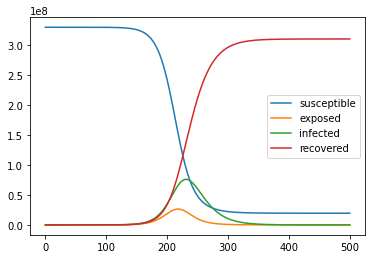

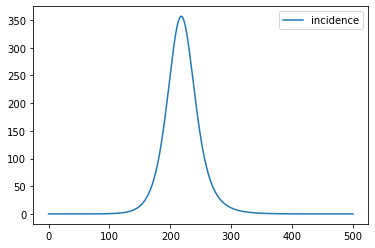

In [5]:
plt.figure()
plt.plot( time, sim_results['susceptible'] )
plt.plot( time, sim_results['exposed'] )
plt.plot( time, sim_results['infected'] )
plt.plot( time, sim_results['recovered']  )
plt.legend(['susceptible', 'exposed', 'infected', 'recovered'])
plt.show()

plt.figure()
plt.plot( time, sim_results['incidence'] )
plt.legend(['incidence'])
plt.show()

# Simulation with governmental measures

Rules defined by the government are implemented. As the infection rate goes beyond a threshold, measures are taken, reducing the effective values of the parameter $\beta$. In case the rate falls below a second threshold, the measures are released.

In [6]:
dy.clear()

system = dy.enter_system()

# step size: 0.1 days
Ts = 0.1

incidence_upper     = dy.system_input( dy.DataTypeFloat64(1), name='incidence_upper', default_value=50,      value_range=[0, 100], title="incidence above which measures are taken")
incidence_lower     = dy.system_input( dy.DataTypeFloat64(1), name='incidence_lower', default_value=10,      value_range=[0, 100], title="incidence below which measures are released")
sigma               = dy.system_input( dy.DataTypeFloat64(1), name='sigma',           default_value=1/5.2,   value_range=[0, 1],    title="sigma (model parameter)")
gamma               = dy.system_input( dy.DataTypeFloat64(1), name='gamma',           default_value=1.0/18,  value_range=[0, 0.2],  title="gamma (model parameter)")

# the diagram
beta_0 = 1.0/18 * 2          # already reduced beta yielding R = 2 (the effect of weak measures, e.g., masks)
beta_lockdown = 1.0/18 * 0.9 # the model parameter for staying at home


def control(susceptible, infected, recovered, infection_rate, incidence):
    # the controller, i.e., rules defined by the government
    #
    # This is a state machine that has two states 'no_measures' and 'lockdown'.
    # Steate transitions are triggered based on measurements.
    #
    
    with dy.sub_statemachine( "statemachine1" ) as switch:
        with switch.new_subsystem('no_measures') as system:
            
            # in the case of high infection rates go into lockdown
            go_into_lockdown = incidence > incidence_upper

            # parameter beta in the absence of measures
            beta_controlled = dy.float64(beta_0)

            next_state = dy.conditional_overwrite(signal=dy.int32(-1), condition=go_into_lockdown, new_value=1 ) # state transition to 'lockdown' (1) 
            system.set_switched_outputs([ beta_controlled ], next_state)


        with switch.new_subsystem('lockdown') as system:

            # as the infection rate falls below a threshold, the measures are stopped
            release_lockdown = incidence < incidence_lower

            # parameter beta during lockdown
            beta_controlled = dy.float64(beta_lockdown)

            next_state = dy.conditional_overwrite(signal=dy.int32(-1), condition=release_lockdown, new_value=0 ) # state transition to 'no_measures' (0)
            system.set_switched_outputs([ beta_controlled ], next_state)

        
    beta_controlled = switch.outputs[0]
    
    return beta_controlled


# (1) placeholders for the feedback signals
susceptible             = dy.signal()
exposed                 = dy.signal()
infected                = dy.signal()
recovered               = dy.signal()
infection_rate          = dy.signal()
measured_infection_rate = dy.signal()
measured_incidence      = dy.signal()

# the controller (the government taking decisions)
beta_controlled = control(susceptible, infected, recovered, infection_rate=measured_infection_rate, incidence=measured_incidence)

# the simulated model
_susceptible, _exposed, _infected, _recovered, _infection_rate, _recovery_rate, _R = pandemic_SEIR_model(N = 3.3E8, beta = beta_controlled, sigma = sigma, gamma = gamma, I_0=10000, Ts = Ts)


# assign concrete signals to the placeholders (1)
susceptible    << _susceptible
exposed        << _exposed 
infected       << _infected
recovered      << _recovered
infection_rate << _infection_rate

# the measurement model, i.e., the delayed observation of newly infected individuals
# NOTE: the duration of the delay shall be extended 
measured_infection_rate << dy.delay( infection_rate )

# measured incidence
measured_incidence << measured_infection_rate*7/100000.0

# define output(s)
dy.append_primay_ouput(dy.sum(dy.float64(Ts)),  'time')
dy.append_primay_ouput(beta_controlled,         'beta_controlled')
dy.append_primay_ouput(susceptible,             'susceptible')
dy.append_primay_ouput(exposed,                 'exposed')
dy.append_primay_ouput(infected,                'infected')
dy.append_primay_ouput(recovered,               'recovered')
dy.append_primay_ouput(infection_rate,          'infection_rate')
dy.append_primay_ouput(measured_incidence,      'incidence')
dy.append_primay_ouput(measured_infection_rate, 'measured_infection_rate')

# generate code for Web Assembly (wasm), requires emcc (emscripten) to build
code_gen_results = dy.generate_code(template=dy.WasmRuntime(), folder="generated/pandemic_control_controlled", build=True)

compiling system Subsystem1000_no_measures (level 1)... 
determining the computation order...
building execution paths...
All dependencies are resolved.
compiling system Subsystem1001_lockdown (level 1)... 
determining the computation order...
building execution paths...
All dependencies are resolved.
compiling system simulation (level 0)... 
determining the computation order...
building execution paths...
All dependencies are resolved.
Generated code will be written to generated/pandemic_control_controlled .
Running compiler: emcc --bind -s MODULARIZE=1 -s EXPORT_NAME="ORTD_simulator" generated/pandemic_control_controlled/main.cpp -g4 -s -o generated/pandemic_control_controlled/main.js
Compilation result:  0


In [7]:
compiled_system = dyexe.CompiledCode(code_gen_results)
sim_results = dyexe.run_batch_simulation(dyexe.SystemInstance(compiled_system), input_data={}, N=5000)
time = sim_results['time']

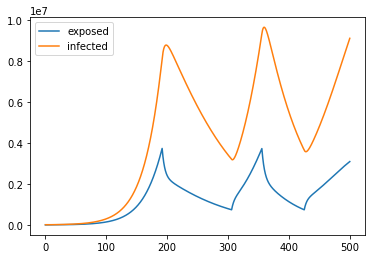

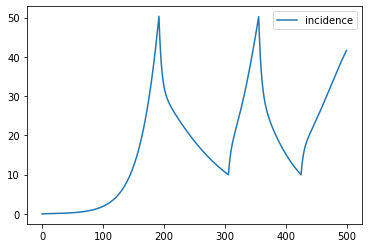

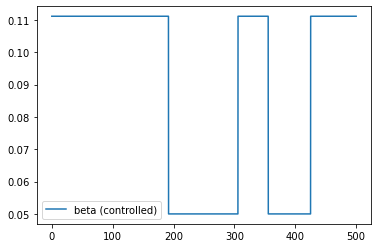

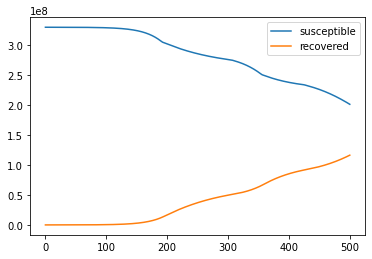

In [8]:
plt.figure()
plt.plot( time, sim_results['exposed'] )
plt.plot( time, sim_results['infected'] )
plt.legend(['exposed', 'infected'])
plt.show()

plt.figure()
plt.plot( time, sim_results['incidence'] )
plt.legend(['incidence'])
plt.show()

plt.figure()
plt.plot( time, sim_results['beta_controlled'] )
plt.legend(['beta (controlled)'])
plt.show()

plt.figure()
plt.plot( time, sim_results['susceptible'] )
plt.plot( time, sim_results['recovered']  )
plt.legend(['susceptible', 'recovered'])
plt.show()